In [2]:
import xarray as xr
import numpy as np
import pyproj as proj
import random
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib as mpl
import time
import cartopy.crs as ccrs
import os
import copy as cp

# Load config

In [3]:
NTEST = 'k-cosine-w-cos_30noresamp'
path_save = '/storage/mathilde/MainProject/1_ExternalProcesses/LagrangianTracking/Clustering/Last_Version/config_k-cosine-w-cos_30noresampnoresamp_goodw/'
path_save_analysis = path_save
Dataset_path = '/storage/mathilde/MainProject/1_ExternalProcesses/LagrangianTracking/Clustering/training_25years_100000.nc'
length_days = 550
perctest = 0.1
perctrain = 0.8

In [4]:
def split_sets(lats_all, lons_all, temps, sals, depths, perctest, perctrain):
    
    s0, s1 = lats_all.shape
    data = np.concatenate((lats_all,lons_all), axis=1)
    
    # shuffle the dataset before splitting 
    random.seed(4)
    random.shuffle(data)
    random.seed(4)
    random.shuffle(temps)
    random.seed(4)
    random.shuffle(sals)
    random.seed(4)
    random.shuffle(depths)
    lats_test = data[:int(perctest*s0), 0:s1]
    lons_test = data[:int(perctest*s0), s1:]

    lats_train = data[int(perctest*s0):int(perctest*s0)+int(perctrain*s0), 0:s1]
    lons_train = data[int(perctest*s0):int(perctest*s0)+int(perctrain*s0), s1:]

    lats_valid = data[int(perctest*s0)+int(perctrain*s0):, 0:s1]
    lons_valid = data[int(perctest*s0)+int(perctrain*s0):, s1:]

    temps_test = temps[:int(perctest*s0),:]
    sals_test = sals[:int(perctest*s0),:]
    depths_test = depths[:int(perctest*s0),:]
    
    temps_train =temps[int(perctest*s0):int(perctest*s0)+int(perctrain*s0),:]
    sals_train = sals[int(perctest*s0):int(perctest*s0)+int(perctrain*s0),:]
    depths_train = depths[int(perctest*s0):int(perctest*s0)+int(perctrain*s0),:]
    
    temps_valid = temps[int(perctest*s0)+int(perctrain*s0):,:]
    sals_valid = sals[int(perctest*s0)+int(perctrain*s0):,:]
    depths_valid = depths[int(perctest*s0)+int(perctrain*s0):,:]
    
    return lats_test, lons_test, lats_train, lons_train, lats_valid, lons_valid, temps_train, temps_test, temps_valid, sals_train, sals_test, sals_valid, depths_train, depths_test, depths_valid

def extract(Dataset_path, length_days) :
    
    ds = xr.open_dataset(Dataset_path)
    lats = ds.lat[:,0:length_days].values # keep only one year of data
    lons = ds.lon[:,0:length_days].values
    temps = ds.temperature[:,0:length_days].values
    sal = ds.salinity[:,0:length_days].values
    depths = ds.z[:,0:length_days].values
    
    return lats, lons, temps, sal, depths

In [5]:
CENTROID=np.load(path_save+'centroids'+NTEST+'.npy', allow_pickle = True)
LABELS_TEST=np.load(path_save+'labels_test'+NTEST+'.npy', allow_pickle = True)
X_REDUCED_TEST=np.load(path_save+'X_reduced_test'+NTEST+'.npy', allow_pickle = True)
LATS_TEST=np.load(path_save+'lats_test'+NTEST+'.npy', allow_pickle = True)
LONS_TEST=np.load(path_save+'lons_test'+NTEST+'.npy', allow_pickle = True)
LATS_TRAIN=np.load(path_save+'lats_train'+NTEST+'.npy', allow_pickle = True)
LONS_TRAIN=np.load(path_save+'lons_train'+NTEST+'.npy', allow_pickle = True)
LABELS_VALID=np.load(path_save+'labels_valid'+NTEST+'.npy', allow_pickle = True)
X_REDUCED_VALID=np.load(path_save+'X_reduced_valid'+NTEST+'.npy', allow_pickle = True)
LATS_VALID=np.load(path_save+'lats_valid'+NTEST+'.npy', allow_pickle = True)
LONS_VALID=np.load(path_save+'lons_valid'+NTEST+'.npy', allow_pickle = True)
TEMPS_VALID=np.load(path_save+'temps_valid'+NTEST+'.npy', allow_pickle = True)
SALS_VALID=np.load(path_save+'sals_valid'+NTEST+'.npy', allow_pickle = True)
TEMPS_TEST=np.load(path_save+'temps_test'+NTEST+'.npy', allow_pickle = True)
SALS_TEST=np.load(path_save+'sals_test'+NTEST+'.npy', allow_pickle = True)
TEMPS_TRAIN=np.load(path_save+'temps_train'+NTEST+'.npy', allow_pickle = True)
SALS_TRAIN=np.load(path_save+'sals_train'+NTEST+'.npy', allow_pickle = True)
    
dists_test=np.load(path_save+'distances_test.npy', allow_pickle=True)

lats_all,lons_all, temps, sals, depths = extract(Dataset_path, length_days)
lats_test, lons_test, lats_train, lons_train, lats_valid, lons_valid, temps_train, temps_test, temps_valid, sals_train, sals_test, sals_valid, depths_train, depths_test, depths_valid= split_sets(lats_all, lons_all, temps, sals, depths, perctest, perctrain)


In [6]:
# Load the WOD data
path_wod = '/storage/mathilde/MainProject/1_ExternalProcesses/Datasets/WOD_Climatology/'
clim = xr.open_dataset(path_wod+'CompleteClimatology.nc')
Tclim = clim.temp
Sclim = clim.sal
O2clim = clim['diss oxy']

maskLCW  = np.genfromtxt('MaskLCW4.csv', delimiter=',')
maskLCW  = np.logical_not(maskLCW)
maskNACW = np.genfromtxt('MaskNACW.csv', delimiter=',')
maskNACW = np.logical_not(maskNACW)

drange_LCW = range(9,30) 
drange_NACW = range(15,25)

TLCW = [] ; SLCW = [] ; TNACW = [] ; SNACW = [] ; O2LCW = []
for d in drange_LCW :
    dum = np.ma.array(Tclim[d,:,:], mask=maskLCW).filled(fill_value=np.nan).flatten()
    TLCW.extend( dum[ ~np.isnan(dum) ] )
    dum = np.ma.array(Sclim[d,:,:], mask=maskLCW).filled(fill_value=np.nan).flatten()
    SLCW.extend( dum[ ~np.isnan(dum) ] )
    dum = np.ma.array(O2clim[d,:,:], mask=maskLCW).filled(fill_value=np.nan).flatten()
    O2LCW.extend( dum[ ~np.isnan(dum) ] )
for d in drange_NACW :
    dum = np.ma.array(Tclim[d,:,:], mask=maskNACW).filled(fill_value=np.nan).flatten()
    TNACW.extend( dum[ ~np.isnan(dum) ] )
    dum = np.ma.array(Sclim[d,:,:], mask=maskNACW).filled(fill_value=np.nan).flatten()
    SNACW.extend( dum[ ~np.isnan(dum) ] )

oldO2 = O2LCW
SLCW = [SLCW[i] for i in range(len(SLCW)) if oldO2[i]>250.]
TLCW = [TLCW[i] for i in range(len(TLCW)) if oldO2[i]>250.]
    

# T-S Analysis

In [10]:
# plot density plots for each group

Col = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:cyan']

L1 = [1,3,6,7,8,9,10,18,19,23,27,29] # Retro
L2 = [21] # Slope Sea avant retro
L3 = [2,17,21,22,25] # Slope Sea
L4 = [26] # Labrador Sea
L5 = [0,4,5,12,13,14,15,16,20] # Labrador Shelf
L6 = [11,28] # South
L7 = [24] # Belle Isle

Ls = [L1,L3,L4,L5,L6,L7]
labels = ['Retroflected', 'Westward-flowing', 'Labrador Sea', 'Labrador Shelf', 'Southward-flowing', 'Belle Isle']
Col = ['tab:red', 'tab:green', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:cyan']

0 / 6


/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: The following kwargs were not used by contour: 'linewidth'


1 / 6
2 / 6
3 / 6
4 / 6
5 / 6


/aos/home/mathilde/miniconda3/envs/Mython3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: The following kwargs were not used by contour: 'linewidth'


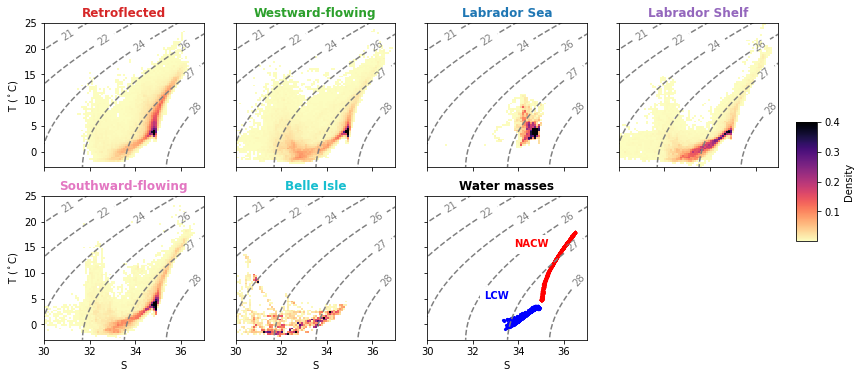

<Figure size 432x288 with 0 Axes>

In [17]:
s_all = [] ; t_all = []
for superclust in Ls:
    s = [] ; t = []
    for n in range(len(LABELS_TEST)):
        if LABELS_TEST[n] in superclust :
            s.extend(SALS_TEST[n,:])
            t.extend(TEMPS_TEST[n,:])
    s_all.append(s) ; t_all.append(t)

# plot
smin = 30 ; smax = 37
tmin = -3 ; tmax=25

# for isopycnals ---
import seawater.eos80 as sw

xdim=(smax-smin)
ydim=(tmax-tmin)
dens = np.zeros((ydim,xdim))
ti = np.linspace(tmin,tmax+1,ydim)
si = np.linspace(smin,smax+1,xdim)
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=sw.dens0(si[i],ti[j])-1000.
# ---

f = plt.figure(figsize = (12,5.5))  
cmap = mpl.cm.magma_r
cmap.set_under('white')
for c in range(len(Ls)):
    print(c, '/', len(Ls))
    ax = f.add_subplot(2,4,c+1)
    h = ax.hist2d(s_all[c], t_all[c], bins = 80, range = [[30, 37], [-3, 25]], density=True, cmap = cmap, vmin = 0.001, vmax = 0.4)
    #cbar = f.colorbar(h[3], ax=ax)
    ax.set_title(labels[c], color=Col[c], fontweight='bold')
    if c==0 or c==4:
        ax.set_ylabel('T ($^\circ$C)')
    else:
        ax.yaxis.set_ticklabels([])
    if c>3:
        ax.set_xlabel('S')
    else:
        ax.xaxis.set_ticklabels([])
    
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='grey', linewidth=1)
    plt.clabel(CS, fontsize=10, inline=1, fmt='%1.0f')
    
# Add reference water masses
ax = f.add_subplot(2,4,c+2, sharex=ax, sharey=ax)
ax.set_title('Water masses', fontweight='bold')
ax.scatter(SNACW,TNACW,s=10, color='r', lw=0, label='NACW')
ax.scatter(SLCW,TLCW,s=10, color='b', lw=0, label='LCW')
ax.set_xlabel('S')
ax.yaxis.set_ticklabels([])
CS = plt.contour(si,ti,dens, linestyles='dashed', colors='grey', linewidth=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%1.0f')
plt.text(33.8, 15, 'NACW', fontweight='bold', c='r', backgroundcolor='w')
plt.text(32.5, 5, 'LCW', fontweight='bold', c='b', backgroundcolor='w')
    
f.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.9)
cbar_ax = f.add_axes([0.92, 0.35, 0.025, 0.3])
cbar = f.colorbar(h[3], cax=cbar_ax)
cbar.set_label('Density')
    
#plt.tight_layout()
plt.savefig(path_save+'Figs/T-S_2.png', dpi=300)
plt.show()
plt.clf()